In [1]:
import gymnasium as gym
import numpy as np
from copy import deepcopy
import torch
from torch.distributions import Normal
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.utils.data import Dataset, DataLoader
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
import imageio
import pandas as pd
from tqdm import tqdm
from PIL import Image
from stable_baselines3.dqn.policies import MlpPolicy
import matplotlib.pyplot as plt


In [2]:
import gc
gc.collect()

7

In [3]:
!nvidia-smi

# clean up memory forcefully
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device





Sat Apr 13 22:29:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.06              Driver Version: 545.23.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti     On  | 00000000:01:00.0 Off |                  N/A |
|  0%   41C    P8              16W / 250W |    968MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

device(type='cuda')

In [4]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class CustomDataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32,device=device)
        self.actions = torch.tensor(actions, dtype=torch.float32,device=device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.norm1 = nn.LayerNorm(32)
        self.fc2 = nn.Linear(32, 32)
        self.norm2 = nn.LayerNorm(32)
        self.fc3 = nn.Linear(32, output_dim)

    def forward(self, x):
        x = F.relu(self.norm1(self.fc1(x)))
        x = F.relu(self.norm2(self.fc2(x)))
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    

Using device: cuda


In [10]:
from stable_baselines3.common.env_util import make_vec_env as make_vec_env_sb3
env_id="MountainCar-v0"
#env = make_vec_env_sb3(env_id, n_envs=1)
observations= np.load("../dataset/obs.npy", allow_pickle=True)
actions = np.load("../dataset/actions.npy", allow_pickle=True)
rewards = np.load("../dataset/rewards.npy", allow_pickle=True)
dones = np.load("../dataset/dones.npy", allow_pickle=True)
info = np.load("../dataset/info.npy", allow_pickle=True)
next_obs = np.load("../dataset/next_obs.npy", allow_pickle=True)
observations=observations.squeeze()
actions=actions.squeeze()
rewards=rewards.squeeze()
dones=dones.squeeze()
info=info.squeeze()
next_obs=next_obs.squeeze()
# observations = observations[:1000]
# actions = actions[:1000]
print(observations.shape, actions.shape, rewards.shape, dones.shape, info.shape, next_obs.shape)
print(observations[0], actions[0], rewards[0], dones[0], info[0], next_obs[0])
env = make_vec_env_sb3(env_id, n_envs=1)

print(env.action_space.n)
print(env.observation_space.shape[0])

(500000, 2) (500000,) (500000,) (500000,) (500000,) (500000, 2)
[-0.43945786  0.        ] 0 -1.0 False {'TimeLimit.truncated': False} [-0.44108224 -0.00162438]
3
2


In [11]:
class mydataset(Dataset):
    def __init__(self, observations, actions):
        self.observations = torch.tensor(observations, dtype=torch.float32).to(device)
        self.actions = torch.tensor(actions, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        observation = self.observations[idx]
        action = self.actions[idx]
        return observation, action

In [12]:

policy_network = PolicyNetwork(
    env.observation_space.shape[0],env.action_space.n ).to(device)
# nn init kaiming
torch.nn.init.kaiming_normal_(policy_network.fc1.weight)
torch.nn.init.kaiming_normal_(policy_network.fc2.weight)
torch.nn.init.kaiming_normal_(policy_network.fc3.weight)



train_dataset = CustomDataset(observations, actions)

optimizer = torch.optim.Adam(policy_network.parameters(), lr=1e-3,weight_decay=1e-5)


# Training loop
num_epochs = 1
batch_size = 128

train_dataloader = DataLoader(train_dataset , batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset , batch_size=batch_size, shuffle=True)
loss_func = nn.CrossEntropyLoss()
log_interval = len(observations)//100
num_test=10

now_log=0
now_pos=0
graph=[]
eval_rewards=[]
for epoch in range(num_epochs):
    policy_network.train()

    # Compute the log probabilities of the actions
    pbar=tqdm(train_dataloader,position=0,leave=True)
    now_log=0
    now_pos=0
    for step, (obs_batch,act_batch) in enumerate(pbar):
        now_log+=obs_batch.shape[0]
        now_pos+=obs_batch.shape[0]
        
        logits = policy_network(obs_batch)
        # cross entropy
        loss=loss_func(logits, act_batch.long())
        
        # Optimize the policy
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()




        #scheduler

        graph.append(loss.detach().item())
        if now_log>=log_interval:
            now_log-=log_interval
            
            policy_network.eval()  # 切换到评估模式

            

            total_reward=0
            # test the policy and save as the first test as gif
            frames = []
            saved_frame = False
            for _ in range(num_test):
                state = env.reset()
                done = False
                while not done:
                    state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
                    with torch.no_grad():
                        action = Categorical(logits=(policy_network(state_tensor))).sample().cpu().numpy()[0]
                        
                    state, reward, done, _ = env.step(action)  # 执行动作
                    total_reward += reward
                    if not saved_frame:
                        frame = env.render(mode="rgb_array")
                        frames.append(frame)  # 添加到帧列表中
                # 保存为GIF
                if not saved_frame:
                    saved_frame = True
                    image_path = f"epoch_{epoch+1}_iteration_{now_pos}.gif"
                    imageio.mimsave("./gif/"+image_path, frames)


            
            print(total_reward/num_test)
                
            eval_rewards.append(total_reward/num_test)

            policy_network.train()      
        pbar.set_description((f"Epoch [{epoch+1}/{num_epochs}]"))
        pbar.set_postfix({"loss":loss.detach().item()})
env.close()

    


Epoch [1/1]:   1%|          | 31/3907 [00:00<00:25, 154.67it/s, loss=0.792]/tmp/ipykernel_954097/938292622.py:71: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025847094/work/torch/csrc/utils/tensor_new.cpp:275.)
  state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
Epoch [1/1]:   1%|▏         | 49/3907 [00:05<09:27,  6.80it/s, loss=0.73]  

[-200.]


Epoch [1/1]:   3%|▎         | 113/3907 [00:11<05:32, 11.42it/s, loss=0.701]

[-200.]


Epoch [1/1]:   3%|▎         | 129/3907 [00:16<08:52,  7.10it/s, loss=0.788]

[-200.]


Epoch [1/1]:   5%|▍         | 190/3907 [00:21<06:02, 10.26it/s, loss=0.673]

[-200.]


Epoch [1/1]:   5%|▌         | 206/3907 [00:26<08:51,  6.97it/s, loss=0.615]

[-200.]


Epoch [1/1]:   7%|▋         | 268/3907 [00:31<06:03, 10.00it/s, loss=0.556]

[-200.]


Epoch [1/1]:   7%|▋         | 284/3907 [00:36<08:39,  6.97it/s, loss=0.528]

[-200.]


Epoch [1/1]:   9%|▉         | 347/3907 [00:41<05:52, 10.09it/s, loss=0.448]

[-200.]


Epoch [1/1]:   9%|▉         | 363/3907 [00:46<08:19,  7.10it/s, loss=0.362]

[-197.2]


Epoch [1/1]:  11%|█         | 425/3907 [00:51<05:33, 10.45it/s, loss=0.288]

[-160.6]


Epoch [1/1]:  11%|█▏        | 441/3907 [00:55<07:28,  7.73it/s, loss=0.212]

[-149.5]


Epoch [1/1]:  13%|█▎        | 502/3907 [00:59<04:34, 12.41it/s, loss=0.317]

[-139.3]


Epoch [1/1]:  13%|█▎        | 518/3907 [01:03<06:38,  8.51it/s, loss=0.284]

[-132.8]


Epoch [1/1]:  15%|█▍        | 582/3907 [01:06<04:03, 13.64it/s, loss=0.321]

[-145.6]


Epoch [1/1]:  15%|█▌        | 598/3907 [01:09<05:10, 10.67it/s, loss=0.215]

[-120.6]


Epoch [1/1]:  17%|█▋        | 659/3907 [01:12<03:32, 15.32it/s, loss=0.204]

[-127.6]


Epoch [1/1]:  17%|█▋        | 675/3907 [01:17<05:41,  9.46it/s, loss=0.331]

[-142.3]


Epoch [1/1]:  19%|█▉        | 739/3907 [01:20<03:31, 15.00it/s, loss=0.186]

[-120.3]


Epoch [1/1]:  19%|█▉        | 756/3907 [01:22<04:33, 11.53it/s, loss=0.198]

[-115.2]


Epoch [1/1]:  21%|██        | 812/3907 [01:25<03:17, 15.64it/s, loss=0.274]

[-114.8]


Epoch [1/1]:  21%|██        | 827/3907 [01:28<04:16, 12.02it/s, loss=0.214]

[-113.5]


Epoch [1/1]:  23%|██▎       | 891/3907 [01:31<02:49, 17.78it/s, loss=0.197]

[-107.]


Epoch [1/1]:  23%|██▎       | 906/3907 [01:35<05:01,  9.97it/s, loss=0.293]

[-117.9]


Epoch [1/1]:  25%|██▍       | 967/3907 [01:38<03:14, 15.10it/s, loss=0.268] 

[-122.]


Epoch [1/1]:  26%|██▌       | 1015/3907 [01:42<03:15, 14.81it/s, loss=0.24]

[-121.9]


Epoch [1/1]:  26%|██▋       | 1032/3907 [01:45<04:16, 11.22it/s, loss=0.155] 

[-118.4]


Epoch [1/1]:  28%|██▊       | 1089/3907 [01:47<02:44, 17.16it/s, loss=0.122]

[-100.6]


Epoch [1/1]:  28%|██▊       | 1106/3907 [01:50<03:32, 13.19it/s, loss=0.215]

[-110.6]


Epoch [1/1]:  30%|██▉       | 1165/3907 [01:55<03:12, 14.23it/s, loss=0.235]

[-128.4]


Epoch [1/1]:  30%|███       | 1181/3907 [01:59<04:57,  9.17it/s, loss=0.127] 

[-113.9]


Epoch [1/1]:  32%|███▏      | 1245/3907 [02:02<02:59, 14.85it/s, loss=0.183]

[-121.9]


Epoch [1/1]:  32%|███▏      | 1261/3907 [02:05<03:53, 11.33it/s, loss=0.263]

[-114.3]


Epoch [1/1]:  34%|███▍      | 1322/3907 [02:07<02:31, 17.03it/s, loss=0.106]

[-113.3]


Epoch [1/1]:  34%|███▍      | 1338/3907 [02:10<03:29, 12.26it/s, loss=0.189]

[-121.2]


Epoch [1/1]:  36%|███▌      | 1402/3907 [02:13<02:14, 18.58it/s, loss=0.224] 

[-129.9]


Epoch [1/1]:  36%|███▋      | 1418/3907 [02:15<03:01, 13.74it/s, loss=0.232]

[-108.8]


Epoch [1/1]:  38%|███▊      | 1480/3907 [02:18<02:09, 18.75it/s, loss=0.263] 

[-115.7]


Epoch [1/1]:  38%|███▊      | 1496/3907 [02:20<02:55, 13.76it/s, loss=0.175]

[-104.]


Epoch [1/1]:  40%|███▉      | 1559/3907 [02:24<02:24, 16.30it/s, loss=0.125] 

[-109.7]


Epoch [1/1]:  40%|████      | 1576/3907 [02:29<03:54,  9.93it/s, loss=0.115] 

[-122.1]


Epoch [1/1]:  42%|████▏     | 1636/3907 [02:32<02:30, 15.11it/s, loss=0.206] 

[-110.]


Epoch [1/1]:  42%|████▏     | 1652/3907 [02:35<03:18, 11.38it/s, loss=0.151] 

[-106.1]


Epoch [1/1]:  44%|████▍     | 1711/3907 [02:37<02:15, 16.22it/s, loss=0.208] 

[-111.5]


Epoch [1/1]:  44%|████▍     | 1726/3907 [02:40<02:53, 12.59it/s, loss=0.181]

[-111.3]


Epoch [1/1]:  46%|████▌     | 1793/3907 [02:43<01:51, 19.00it/s, loss=0.205]

[-100.3]


Epoch [1/1]:  46%|████▋     | 1809/3907 [02:45<02:36, 13.39it/s, loss=0.167]

[-118.7]


Epoch [1/1]:  48%|████▊     | 1863/3907 [02:48<02:01, 16.83it/s, loss=0.167] 

[-117.4]


Epoch [1/1]:  49%|████▉     | 1909/3907 [02:51<01:48, 18.50it/s, loss=0.159] 

[-100.9]


Epoch [1/1]:  49%|████▉     | 1926/3907 [02:54<02:36, 12.64it/s, loss=0.187] 

[-108.5]


Epoch [1/1]:  51%|█████     | 1989/3907 [02:57<01:45, 18.22it/s, loss=0.154]

[-112.7]


Epoch [1/1]:  51%|█████▏    | 2006/3907 [02:59<02:18, 13.75it/s, loss=0.213] 

[-115.9]


Epoch [1/1]:  53%|█████▎    | 2067/3907 [03:02<01:31, 20.02it/s, loss=0.196] 

[-106.3]


Epoch [1/1]:  53%|█████▎    | 2084/3907 [03:05<02:14, 13.51it/s, loss=0.251] 

[-106.7]


Epoch [1/1]:  55%|█████▍    | 2144/3907 [03:08<01:38, 17.97it/s, loss=0.098] 

[-122.6]


Epoch [1/1]:  55%|█████▌    | 2160/3907 [03:10<02:10, 13.38it/s, loss=0.186] 

[-110.5]


Epoch [1/1]:  57%|█████▋    | 2222/3907 [03:13<01:31, 18.43it/s, loss=0.127] 

[-107.9]


Epoch [1/1]:  57%|█████▋    | 2238/3907 [03:16<02:16, 12.22it/s, loss=0.263]

[-112.1]


Epoch [1/1]:  59%|█████▉    | 2302/3907 [03:19<01:29, 17.88it/s, loss=0.202] 

[-107.8]


Epoch [1/1]:  59%|█████▉    | 2319/3907 [03:22<02:04, 12.76it/s, loss=0.161] 

[-112.]


Epoch [1/1]:  61%|██████    | 2379/3907 [03:25<01:25, 17.85it/s, loss=0.125] 

[-114.8]


Epoch [1/1]:  61%|██████▏   | 2396/3907 [03:27<01:57, 12.91it/s, loss=0.157] 

[-109.9]


Epoch [1/1]:  63%|██████▎   | 2457/3907 [03:30<01:17, 18.67it/s, loss=0.129] 

[-110.5]


Epoch [1/1]:  63%|██████▎   | 2474/3907 [03:33<01:49, 13.12it/s, loss=0.124] 

[-116.2]


Epoch [1/1]:  65%|██████▍   | 2533/3907 [03:36<01:17, 17.78it/s, loss=0.0878]

[-107.4]


Epoch [1/1]:  65%|██████▌   | 2549/3907 [03:38<01:42, 13.22it/s, loss=0.127] 

[-98.1]


Epoch [1/1]:  67%|██████▋   | 2615/3907 [03:42<01:21, 15.92it/s, loss=0.179] 

[-120.5]


Epoch [1/1]:  67%|██████▋   | 2632/3907 [03:45<01:45, 12.09it/s, loss=0.135] 

[-108.2]


Epoch [1/1]:  69%|██████▉   | 2688/3907 [03:48<01:14, 16.29it/s, loss=0.119] 

[-121.3]


Epoch [1/1]:  69%|██████▉   | 2704/3907 [03:52<02:00,  9.97it/s, loss=0.233] 

[-111.]


Epoch [1/1]:  71%|███████   | 2769/3907 [03:55<01:11, 15.89it/s, loss=0.174] 

[-109.1]


Epoch [1/1]:  71%|███████▏  | 2785/3907 [03:58<01:35, 11.76it/s, loss=0.195] 

[-112.]


Epoch [1/1]:  73%|███████▎  | 2848/3907 [04:00<00:57, 18.28it/s, loss=0.158] 

[-105.7]


Epoch [1/1]:  73%|███████▎  | 2865/3907 [04:03<01:19, 13.18it/s, loss=0.111] 

[-101.2]


Epoch [1/1]:  75%|███████▍  | 2924/3907 [04:06<00:54, 18.01it/s, loss=0.243]

[-108.6]


Epoch [1/1]:  75%|███████▌  | 2940/3907 [04:09<01:17, 12.52it/s, loss=0.155] 

[-116.8]


Epoch [1/1]:  77%|███████▋  | 3003/3907 [04:12<00:49, 18.10it/s, loss=0.258] 

[-102.7]


Epoch [1/1]:  77%|███████▋  | 3019/3907 [04:14<01:08, 12.90it/s, loss=0.161] 

[-102.7]


Epoch [1/1]:  79%|███████▉  | 3081/3907 [04:17<00:45, 18.22it/s, loss=0.134] 

[-104.1]


Epoch [1/1]:  79%|███████▉  | 3097/3907 [04:20<00:58, 13.76it/s, loss=0.117] 

[-109.8]


Epoch [1/1]:  81%|████████  | 3158/3907 [04:22<00:37, 19.75it/s, loss=0.115] 

[-111.]


Epoch [1/1]:  81%|████████  | 3174/3907 [04:25<00:53, 13.67it/s, loss=0.127] 

[-100.]


Epoch [1/1]:  83%|████████▎ | 3239/3907 [04:29<00:43, 15.37it/s, loss=0.157] 

[-113.4]


Epoch [1/1]:  83%|████████▎ | 3255/3907 [04:32<00:53, 12.14it/s, loss=0.189] 

[-105.7]


Epoch [1/1]:  85%|████████▍ | 3316/3907 [04:34<00:32, 18.37it/s, loss=0.149] 

[-100.3]


Epoch [1/1]:  85%|████████▌ | 3332/3907 [04:37<00:44, 12.95it/s, loss=0.206] 

[-103.3]


Epoch [1/1]:  87%|████████▋ | 3393/3907 [04:40<00:28, 17.83it/s, loss=0.155] 

[-105.2]


Epoch [1/1]:  87%|████████▋ | 3409/3907 [04:43<00:40, 12.44it/s, loss=0.152] 

[-104.4]


Epoch [1/1]:  89%|████████▉ | 3473/3907 [04:46<00:23, 18.35it/s, loss=0.145] 

[-104.8]


Epoch [1/1]:  89%|████████▉ | 3489/3907 [04:48<00:32, 12.96it/s, loss=0.173] 

[-103.1]


Epoch [1/1]:  91%|█████████ | 3550/3907 [04:51<00:19, 18.08it/s, loss=0.0949]

[-107.2]


Epoch [1/1]:  91%|█████████▏| 3566/3907 [04:54<00:25, 13.59it/s, loss=0.157] 

[-111.5]


Epoch [1/1]:  93%|█████████▎| 3628/3907 [04:57<00:14, 18.73it/s, loss=0.173] 

[-106.2]


Epoch [1/1]:  93%|█████████▎| 3644/3907 [04:59<00:19, 13.31it/s, loss=0.222] 

[-119.]


Epoch [1/1]:  95%|█████████▍| 3706/3907 [05:02<00:10, 18.43it/s, loss=0.121] 

[-115.9]


Epoch [1/1]:  95%|█████████▌| 3722/3907 [05:05<00:14, 12.83it/s, loss=0.101] 

[-117.1]


Epoch [1/1]:  97%|█████████▋| 3785/3907 [05:08<00:06, 18.39it/s, loss=0.09]  

[-103.4]


Epoch [1/1]:  97%|█████████▋| 3802/3907 [05:11<00:08, 13.01it/s, loss=0.102] 

[-103.4]


Epoch [1/1]:  99%|█████████▉| 3864/3907 [05:14<00:02, 17.60it/s, loss=0.188] 

[-112.1]


Epoch [1/1]:  99%|█████████▉| 3881/3907 [05:17<00:02, 12.43it/s, loss=0.0867]

[-121.6]


Epoch [1/1]: 100%|██████████| 3907/3907 [05:19<00:00, 12.23it/s, loss=0.0776]

[-102.5]


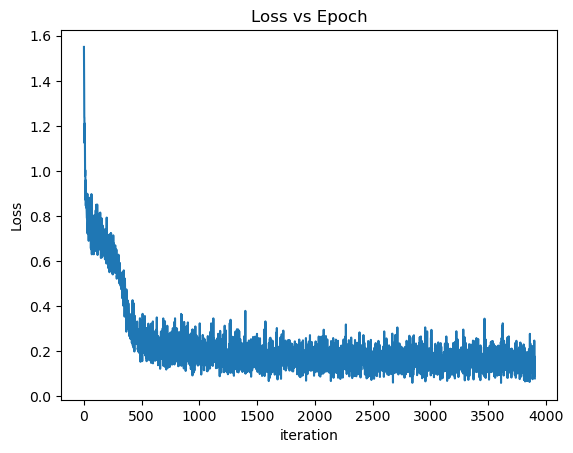

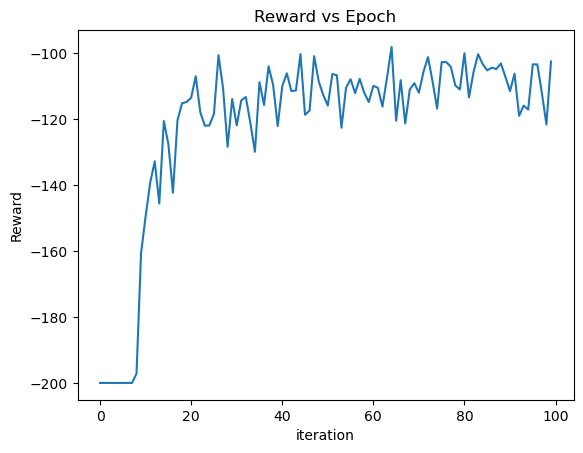

<Figure size 640x480 with 0 Axes>

In [15]:
# save to /mnt/nfs/work/albertliu/RL/CartPole-v1/BC
# draw the loss graph
import matplotlib.pyplot as plt
plt.plot(graph)
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.show()
plt.savefig("./loss.png")

# draw the reward graph
plt.plot(eval_rewards)
plt.xlabel("iteration")
plt.ylabel("Reward")
plt.title("Reward vs Epoch")
plt.show()
plt.savefig("./reward.png")


